# Setup

In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [3]:
SYS_PROJECT_DIR  = '/content/gdrive/MyDrive/Colab Notebooks/musicgen'
SYS_INPUT_DIR    = '/content/gdrive/MyDrive/Colab Notebooks/musicgen/input'
SYS_DP_DIR       = '/content/gdrive/MyDrive/Colab Notebooks/musicgen/dp'
SYS_MODELING_DIR = '/content/gdrive/MyDrive/Colab Notebooks/musicgen/modeling'
SYS_OUTPUT_DIR   = '/content/gdrive/MyDrive/Colab Notebooks/musicgen/output'

In [4]:
import os
import pandas as pd
import shutil

pd.set_option('display.max_columns', None)  # This ensures that all columns are displayed
pd.set_option('display.width', None)        # This ensures that each line of output will be as wide as necessary
pd.set_option('display.max_colwidth', None) # This ensures that columns will not be truncated

# Installs

In [5]:
!pip install -q miditoolkit
!pip install -q music21

!apt-get install fluidsynth | grep -E "error|warning"
!apt-get install libfluidsynth3 | grep -E "error|warning"
!apt-get install fluid-soundfont-gm | grep -E "error|warning"
!pip install -q pyfluidsynth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
Extracting templates from packages: 100%
  Preparing metadata (setup.py) ... done


In [6]:
!pip install -q pandas
!pip install -q pydantic
!pip install -q pydantic_argparse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.8 MB/s eta 0:00:00


In [7]:
!pip install -q transformers==4.38.2
!pip install -q datasets==2.18.0
!pip install -q accelerate==0.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.6 MB/s eta 0:00:00


In [5]:
import sys
import os

musicgen_utils_path = os.path.join(SYS_PROJECT_DIR)
if musicgen_utils_path not in sys.path:
    sys.path.append(musicgen_utils_path)

# Data Preparation

## Data Exploration

### Get basic info

In [ ]:
# from pathlib import Path
# from miditoolkit import MidiFile

# data_musician = "Roxette"

# midi_path = Path(SYS_INPUT_DIR, data_musician, "Crash! Boom! Bang!.1.mid")
# midi_file = MidiFile(midi_path)

# print(midi_file)

### Play Audio

## Chunking the Dataset

In [3]:
MAX_NB_BAR = 8
MIN_NB_NOTES = 20

In [14]:
from pathlib import Path
from tqdm import tqdm
from copy import deepcopy
from miditoolkit import MidiFile
from math import ceil

data_musician = "Roxette"

data_problem_files = [
    Path(SYS_INPUT_DIR, data_musician, "It Must Have Been Love (live studio).3.mid"),
    Path(SYS_INPUT_DIR, data_musician, "The Look.mid"),
]
# merged_out_dir = Path(SYS_INPUT_DIR, data_musician, f"{data_musician}-chunked")
# merged_out_dir.mkdir(parents=True, exist_ok=True)
dp_chunking_output_dir = Path(SYS_DP_DIR, "chunking", data_musician)
midi_paths = list(Path(SYS_INPUT_DIR, data_musician).glob("**/*.mid"))

for i, midi_path in enumerate(tqdm(midi_paths, desc="Chunkiing MID Audio file", unit="file")):
    try:

        # Check if chunks already exist
        chunk_paths = list(dp_chunking_output_dir.glob(f"{midi_path.stem}_*.mid"))
        if len(chunk_paths) > 0:
            print(f"Chunks for {midi_path} already exist, skipping...")
            continue

        # Loads MIDI, merges and saves it
        midi = MidiFile(midi_path)
        ticks_per_cut = MAX_NB_BAR * midi.ticks_per_beat * 4
        nb_cuts = ceil(midi.max_tick / ticks_per_cut)
        if nb_cuts < 2:
            continue

        if midi_path in data_problem_files:
              print(f"Skipping problematic MIDI file {midi_path}")
              continue

        print(f"Processing {midi_path}")
        midis = [deepcopy(midi) for _ in range(nb_cuts)]

        for j, track in enumerate(midi.instruments):  # sort notes as they are not always sorted right
            track.notes.sort(key=lambda x: x.start)
            for midi_short in midis:  # clears notes from shorten MIDIs
                midi_short.instruments[j].notes = []
            for note in track.notes:
                cut_id = note.start // ticks_per_cut
                note_copy = deepcopy(note)
                note_copy.start -= cut_id * ticks_per_cut
                note_copy.end -= cut_id * ticks_per_cut
                midis[cut_id].instruments[j].notes.append(note_copy)

        # Saving MIDIs
        for j, midi_short in enumerate(midis):
            if sum(len(track.notes) for track in midi_short.instruments) < MIN_NB_NOTES:
                continue
            midi_short.dump(dp_chunking_output_dir / f"{midi_path.stem}_{j}.mid")

    except Exception as e:
        print(f"An error occurred while processing {midi_path}: {e}")

Chunkiing MID Audio file:   0%|          | 0/117 [00:00<?, ?file/s]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/It Must Have Been Love (live studio).mid


Chunkiing MID Audio file:   1%|          | 1/117 [00:02<05:46,  2.99s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Fading Like a Flower (Every Time You Leave).mid


Chunkiing MID Audio file:   2%|▏         | 2/117 [00:06<05:55,  3.09s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Spending My Time.mid


Chunkiing MID Audio file:   3%|▎         | 3/117 [00:06<03:50,  2.02s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Crash! Boom! Bang!.mid


Chunkiing MID Audio file:   3%|▎         | 4/117 [00:09<03:55,  2.08s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Here Comes the Weekend (live).mid


Chunkiing MID Audio file:   4%|▍         | 5/117 [00:10<03:28,  1.86s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Crash! Boom! Bang!.1.mid


Chunkiing MID Audio file:   5%|▌         | 6/117 [00:12<03:34,  1.93s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Joyride.mid


Chunkiing MID Audio file:   6%|▌         | 7/117 [00:14<03:14,  1.77s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Spending My Time.1.mid


Chunkiing MID Audio file:   7%|▋         | 8/117 [00:16<03:19,  1.83s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/The Big L..mid


Chunkiing MID Audio file:   8%|▊         | 9/117 [00:18<03:24,  1.90s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Milk And Toast And Honey.mid


Chunkiing MID Audio file:   9%|▊         | 10/117 [00:18<02:40,  1.50s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Dressed for Succes.mid


Chunkiing MID Audio file:   9%|▉         | 11/117 [00:22<04:01,  2.28s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Un dia sin ti (Spending My Time).mid


Chunkiing MID Audio file:  10%|█         | 12/117 [00:23<03:12,  1.83s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/The Big L..1.mid


Chunkiing MID Audio file:  11%|█         | 13/117 [00:25<03:30,  2.03s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Listen to Your Heart.mid


Chunkiing MID Audio file:  12%|█▏        | 14/117 [00:28<03:35,  2.10s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Listen to Your Heart.1.mid


Chunkiing MID Audio file:  13%|█▎        | 15/117 [00:29<03:19,  1.95s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Run to You.mid


Chunkiing MID Audio file:  14%|█▎        | 16/117 [00:30<02:50,  1.69s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/It Must Have Been Love (live studio).1.mid


Chunkiing MID Audio file:  15%|█▍        | 17/117 [00:32<02:29,  1.50s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Harleys & Indians (Riders in the Sky).mid


Chunkiing MID Audio file:  15%|█▌        | 18/117 [00:32<02:12,  1.34s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Sleeping In My Car.mid


Chunkiing MID Audio file:  16%|█▌        | 19/117 [00:35<02:37,  1.60s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Stars.mid


Chunkiing MID Audio file:  17%|█▋        | 20/117 [00:37<02:56,  1.81s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/It Must Have Been Love.mid


Chunkiing MID Audio file:  18%|█▊        | 21/117 [00:37<02:13,  1.39s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Fading Like a Flower (live Brussels 22 10 2001).mid


Chunkiing MID Audio file:  19%|█▉        | 22/117 [00:38<02:01,  1.27s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Dangerous.mid


Chunkiing MID Audio file:  20%|█▉        | 23/117 [00:42<02:54,  1.86s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Run to You.1.mid


Chunkiing MID Audio file:  21%|██        | 24/117 [00:43<02:45,  1.78s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Spending My Time.2.mid


Chunkiing MID Audio file:  21%|██▏       | 25/117 [00:44<02:15,  1.47s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Paint.mid


Chunkiing MID Audio file:  22%|██▏       | 26/117 [00:45<01:59,  1.31s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Crash! Boom! Bang!.2.mid


Chunkiing MID Audio file:  23%|██▎       | 27/117 [00:47<02:21,  1.57s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/It Must Have Been Love (live studio).2.mid


Chunkiing MID Audio file:  25%|██▍       | 29/117 [00:48<01:28,  1.01s/file]

An error occurred while processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/The Look.mid: data byte must be in range 0..127
Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Fading Like a Flower (Every Time You Leave).1.mid


Chunkiing MID Audio file:  26%|██▌       | 30/117 [00:50<01:36,  1.11s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Salvation.mid


Chunkiing MID Audio file:  26%|██▋       | 31/117 [00:51<01:35,  1.11s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Sleeping In My Car.1.mid


Chunkiing MID Audio file:  27%|██▋       | 32/117 [00:53<02:04,  1.46s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Love Is All (Shine Your Light On Me).mid


Chunkiing MID Audio file:  28%|██▊       | 33/117 [00:53<01:40,  1.19s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Queen of Rain.mid


Chunkiing MID Audio file:  29%|██▉       | 34/117 [00:58<03:00,  2.17s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Harleys & Indians (Riders in the Sky).1.mid


Chunkiing MID Audio file:  30%|██▉       | 35/117 [00:59<02:26,  1.78s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/How Do You Do.mid


Chunkiing MID Audio file:  31%|███       | 36/117 [01:00<02:19,  1.72s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Do You Wanna Go the Whole Way_.mid


Chunkiing MID Audio file:  32%|███▏      | 37/117 [01:01<01:58,  1.49s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Paint.1.mid


Chunkiing MID Audio file:  32%|███▏      | 38/117 [01:02<01:44,  1.32s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Spending My Time.3.mid


Chunkiing MID Audio file:  33%|███▎      | 39/117 [01:03<01:30,  1.16s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Milk And Toast And Honey.1.mid


Chunkiing MID Audio file:  34%|███▍      | 40/117 [01:04<01:31,  1.19s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Listen to Your Heart.2.mid


Chunkiing MID Audio file:  35%|███▌      | 41/117 [01:06<01:39,  1.31s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Do You Wanna Go the Whole Way_.1.mid


Chunkiing MID Audio file:  36%|███▌      | 42/117 [01:07<01:28,  1.17s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Sleeping In My Car.2.mid


Chunkiing MID Audio file:  37%|███▋      | 43/117 [01:11<02:23,  1.94s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/The Look.1.mid


Chunkiing MID Audio file:  38%|███▊      | 44/117 [01:13<02:37,  2.15s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Crash! Boom! Bang!.3.mid


Chunkiing MID Audio file:  38%|███▊      | 45/117 [01:15<02:33,  2.13s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Here Comes the Weekend (live).1.mid


Chunkiing MID Audio file:  39%|███▉      | 46/117 [01:17<02:17,  1.94s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Chances.mid


Chunkiing MID Audio file:  40%|████      | 47/117 [01:19<02:13,  1.91s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Dangerous.1.mid


Chunkiing MID Audio file:  41%|████      | 48/117 [01:22<02:39,  2.31s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Love Is All (Shine Your Light On Me).1.mid


Chunkiing MID Audio file:  42%|████▏     | 49/117 [01:23<02:04,  1.83s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Fading Like a Flower (Every Time You Leave).2.mid


Chunkiing MID Audio file:  44%|████▎     | 51/117 [01:24<01:21,  1.24s/file]

Skipping problematic MIDI file /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/It Must Have Been Love (live studio).3.mid
Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Listen to Your Heart.3.mid


Chunkiing MID Audio file:  44%|████▍     | 52/117 [01:26<01:27,  1.35s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Love Is All (Shine Your Light On Me).2.mid


Chunkiing MID Audio file:  45%|████▌     | 53/117 [01:26<01:13,  1.15s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Physical Fascination.mid


Chunkiing MID Audio file:  46%|████▌     | 54/117 [01:29<01:31,  1.45s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/How Do You Do.1.mid


Chunkiing MID Audio file:  47%|████▋     | 55/117 [01:30<01:22,  1.33s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Vulnerable.mid


Chunkiing MID Audio file:  48%|████▊     | 56/117 [01:31<01:17,  1.27s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/The Look.2.mid


Chunkiing MID Audio file:  49%|████▊     | 57/117 [01:31<01:05,  1.09s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/It Must Have Been Love (live studio).4.mid


Chunkiing MID Audio file:  50%|████▉     | 58/117 [01:33<01:10,  1.20s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/The Look.3.mid


Chunkiing MID Audio file:  50%|█████     | 59/117 [01:34<01:09,  1.19s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Joyride.1.mid


Chunkiing MID Audio file:  51%|█████▏    | 60/117 [01:35<01:12,  1.26s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Listen to Your Heart.4.mid


Chunkiing MID Audio file:  52%|█████▏    | 61/117 [01:38<01:28,  1.59s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/The Look.4.mid


Chunkiing MID Audio file:  53%|█████▎    | 62/117 [01:38<01:11,  1.30s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Fading Like a Flower (Every Time You Leave).3.mid


Chunkiing MID Audio file:  54%|█████▍    | 63/117 [01:40<01:11,  1.32s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Fading Like a Flower (Every Time You Leave).4.mid


Chunkiing MID Audio file:  55%|█████▍    | 64/117 [01:41<01:11,  1.34s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/It Must Have Been Love (live studio).5.mid


Chunkiing MID Audio file:  56%|█████▌    | 65/117 [01:42<00:56,  1.09s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/It Must Have Been Love (live studio).6.mid


Chunkiing MID Audio file:  56%|█████▋    | 66/117 [01:43<00:54,  1.07s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/The Big L..2.mid


Chunkiing MID Audio file:  57%|█████▋    | 67/117 [01:45<01:13,  1.47s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Listen to Your Heart.5.mid


Chunkiing MID Audio file:  58%|█████▊    | 68/117 [01:47<01:17,  1.58s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/2 Cinnamon Street.mid


Chunkiing MID Audio file:  59%|█████▉    | 69/117 [01:48<01:02,  1.30s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Fading Like a Flower (Every Time You Leave).5.mid


Chunkiing MID Audio file:  60%|█████▉    | 70/117 [01:49<01:02,  1.33s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Spending My Time.4.mid


Chunkiing MID Audio file:  61%|██████    | 71/117 [01:50<00:53,  1.17s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Crash! Boom! Bang!.4.mid


Chunkiing MID Audio file:  62%|██████▏   | 72/117 [01:52<01:06,  1.48s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Here Comes the Weekend (live).2.mid


Chunkiing MID Audio file:  62%|██████▏   | 73/117 [01:53<01:05,  1.48s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Joyride.2.mid


Chunkiing MID Audio file:  63%|██████▎   | 74/117 [01:55<01:03,  1.48s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Un dia sin ti (Spending My Time).1.mid


Chunkiing MID Audio file:  64%|██████▍   | 75/117 [01:56<00:54,  1.30s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/It Must Have Been Love (live studio).7.mid


Chunkiing MID Audio file:  65%|██████▍   | 76/117 [02:01<01:45,  2.57s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/It Must Have Been Love (live studio).8.mid


Chunkiing MID Audio file:  66%|██████▌   | 77/117 [02:03<01:36,  2.42s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Real Sugar.mid


Chunkiing MID Audio file:  67%|██████▋   | 78/117 [02:05<01:25,  2.19s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Joyride.3.mid


Chunkiing MID Audio file:  68%|██████▊   | 79/117 [02:09<01:42,  2.69s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Joyride.4.mid


Chunkiing MID Audio file:  68%|██████▊   | 80/117 [02:10<01:25,  2.32s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Silver Blue.mid


Chunkiing MID Audio file:  69%|██████▉   | 81/117 [02:13<01:23,  2.31s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Sleeping In My Car.3.mid


Chunkiing MID Audio file:  70%|███████   | 82/117 [02:15<01:18,  2.25s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Do You Wanna Go the Whole Way_.2.mid


Chunkiing MID Audio file:  71%|███████   | 83/117 [02:16<01:02,  1.84s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Spending My Time.5.mid


Chunkiing MID Audio file:  72%|███████▏  | 84/117 [02:16<00:49,  1.51s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Vulnerable.1.mid


Chunkiing MID Audio file:  73%|███████▎  | 85/117 [02:18<00:45,  1.42s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/I'm Sorry.mid


Chunkiing MID Audio file:  74%|███████▎  | 86/117 [02:19<00:47,  1.52s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Listen to Your Heart.6.mid


Chunkiing MID Audio file:  74%|███████▍  | 87/117 [02:21<00:48,  1.62s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/It Must Have Been Love (live studio).9.mid


Chunkiing MID Audio file:  75%|███████▌  | 88/117 [02:27<01:20,  2.79s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/The Look.5.mid


Chunkiing MID Audio file:  76%|███████▌  | 89/117 [02:29<01:10,  2.50s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Listen to Your Heart.7.mid


Chunkiing MID Audio file:  77%|███████▋  | 90/117 [02:31<01:07,  2.50s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Run to You.2.mid


Chunkiing MID Audio file:  78%|███████▊  | 91/117 [02:32<00:54,  2.08s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Listen to Your Heart.8.mid


Chunkiing MID Audio file:  79%|███████▊  | 92/117 [02:34<00:50,  2.00s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Paint.2.mid


Chunkiing MID Audio file:  79%|███████▉  | 93/117 [02:35<00:40,  1.70s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Things Will Never Be the Same.mid


Chunkiing MID Audio file:  80%|████████  | 94/117 [02:36<00:34,  1.52s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Directamente a ti (Run to You).mid


Chunkiing MID Audio file:  81%|████████  | 95/117 [02:37<00:29,  1.35s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Watercolours in the Rain.mid


Chunkiing MID Audio file:  82%|████████▏ | 96/117 [02:38<00:24,  1.17s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/How Do You Do.2.mid


Chunkiing MID Audio file:  83%|████████▎ | 97/117 [02:39<00:26,  1.32s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Almost Unreal.mid


Chunkiing MID Audio file:  84%|████████▍ | 98/117 [02:41<00:25,  1.34s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Sleeping In My Car.4.mid


Chunkiing MID Audio file:  85%|████████▍ | 99/117 [02:43<00:28,  1.60s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Fading Like a Flower (Every Time You Leave).6.mid


Chunkiing MID Audio file:  85%|████████▌ | 100/117 [02:45<00:26,  1.58s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/How Do You Do.3.mid


Chunkiing MID Audio file:  86%|████████▋ | 101/117 [02:46<00:24,  1.56s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Spending My Time.6.mid


Chunkiing MID Audio file:  87%|████████▋ | 102/117 [02:47<00:20,  1.35s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Wish I Could Fly.mid


Chunkiing MID Audio file:  88%|████████▊ | 103/117 [02:48<00:19,  1.36s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/The Look.6.mid


Chunkiing MID Audio file:  89%|████████▉ | 104/117 [02:50<00:17,  1.35s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/I'm Sorry.1.mid


Chunkiing MID Audio file:  90%|████████▉ | 105/117 [02:51<00:17,  1.48s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Spending My Time.7.mid


Chunkiing MID Audio file:  91%|█████████ | 106/117 [02:52<00:14,  1.28s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/The Look.7.mid


Chunkiing MID Audio file:  91%|█████████▏| 107/117 [02:54<00:13,  1.34s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/It Must Have Been Love (live studio).10.mid


Chunkiing MID Audio file:  92%|█████████▏| 108/117 [02:55<00:11,  1.27s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/I'm Sorry.2.mid


Chunkiing MID Audio file:  93%|█████████▎| 109/117 [02:57<00:11,  1.47s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/How Do You Do.4.mid


Chunkiing MID Audio file:  94%|█████████▍| 110/117 [02:58<00:09,  1.33s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/The Look.8.mid


Chunkiing MID Audio file:  95%|█████████▍| 111/117 [02:59<00:08,  1.35s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Harleys & Indians (Riders in the Sky).2.mid


Chunkiing MID Audio file:  96%|█████████▌| 112/117 [03:00<00:06,  1.27s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Silver Blue.1.mid


Chunkiing MID Audio file:  97%|█████████▋| 113/117 [03:01<00:04,  1.10s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Shadow of a Doubt.mid


Chunkiing MID Audio file:  97%|█████████▋| 114/117 [03:03<00:04,  1.47s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Queen of Rain.1.mid


Chunkiing MID Audio file:  98%|█████████▊| 115/117 [03:08<00:04,  2.37s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/The Look.9.mid


Chunkiing MID Audio file:  99%|█████████▉| 116/117 [03:11<00:02,  2.48s/file]

Processing /content/gdrive/MyDrive/Colab Notebooks/musicgen/input/Roxette/Dangerous (7_ version).mid


Chunkiing MID Audio file: 100%|██████████| 117/117 [03:12<00:00,  1.64s/file]


## Tokenization

### MMM: Multi-Track Music Machine tokenization

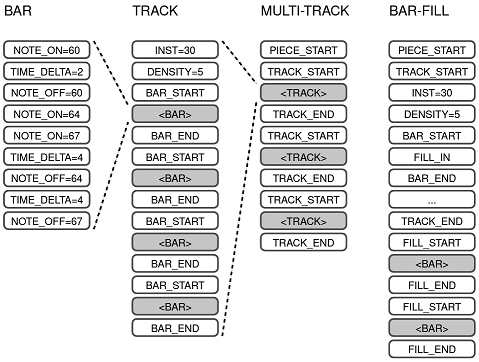

In MMM, the numbers represent the pitch of the notes and the instruments in MIDI notation. For example, in the diagram above, the NOTE_ON=60 is the C4, and the INST=30 means an Overdriven Guitar. You use NOTE_ON/NOTE_OFF to indicate when the note starts and stops sounding and TIME_DELTA to move the timeline. The notes are wrapped inside <BAR_START> and <BAR_END> tokens which are added inside <TRACK_START> and <TRACK_END> pseudo-words that you finally group inside <PIECE_START> and <PIECE_END>: MultriTrack Music Machine!

In [15]:
# !git clone https://github.com/juancopi81/mmm_tokenizer_lmd_clean

Cloning into 'mmm_tokenizer_lmd_clean'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 151 (delta 72), reused 125 (delta 46), pack-reused 0
Receiving objects: 100% (151/151), 9.35 MiB | 9.64 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [34]:
mmm_tokenizer_lmd_clean_path = Path(SYS_PROJECT_DIR, "mmm_tokenizer_lmd_clean")

In [42]:
%cd "$mmm_tokenizer_lmd_clean_path"

/content/gdrive/MyDrive/Colab Notebooks/musicgen/mmm_tokenizer_lmd_clean


In [29]:
# dp_chunking_output_dir = Path("/content/gdrive/MyDrive/musicgen/dp", "chunking", data_musician)

In [14]:
data_musician = "Roxette"
dp_chunking_output_dir = Path(SYS_DP_DIR, "chunking", data_musician)
dp_tokenization_output_dir = Path(SYS_DP_DIR, "tokenization", data_musician)

In [ ]:
!python3 create_dataset_mmm.py --midi-source "$dp_chunking_output_dir" --save-path "$dp_tokenization_output_dir" --num-files-per-iteration 10

### Explore tokenized data

In [15]:
from pathlib import Path
import glob

dataset_name = "lmd_dataset_mmmtrack"
dataset_path = Path(dp_tokenization_output_dir, dataset_name)
dataset_files = glob.glob(f"{dataset_path}/*.txt")
print(f"There are {len(dataset_files)} train and validation files")

There are 191 train and validation files


In [16]:
from datasets import load_dataset
dataset = load_dataset("text", data_files=dataset_files)

train_dataset = dataset["train"]
train_df = train_dataset.to_pandas()

Resolving data files:   0%|          | 0/191 [00:00<?, ?it/s]

In [17]:
train_df.head(1)

text
0  PIECE_START TIME_SIGNATURE=4_4 GENRE=POP TRACK_START INST=5 DENSITY=2 BAR_START BAR_END BAR_START NOTE_ON=62 TIME_DELTA=2.533333333333333 NOTE_OFF=62 TIME_DELTA=1.4666666666666668 NOTE_ON=62 TIME_DELTA=1.416666666666667 NOTE_OFF=62 TIME_DELTA=0.583333333333333 NOTE_ON=62 TIME_DELTA=3.033333333333333 NOTE_OFF=62 TIME_DELTA=0.9666666666666668 NOTE_ON=62 TIME_DELTA=2.0 NOTE_ON=60 TIME_DELTA=0.3333333333333339 NOTE_OFF=62 TIME_DELTA=3.666666666666666 NOTE_OFF=60 BAR_END BAR_START NOTE_ON=62 NOTE_ON=60 TIME_DELTA=0.4166666666666667 NOTE_OFF=60 TIME_DELTA=2.3333333333333335 NOTE_OFF=62 TIME_DELTA=1.25 NOTE_ON=62 TIME_DELTA=1.3666666666666671 NOTE_OFF=62 TIME_DELTA=1.6333333333333329 NOTE_ON=62 TIME_DELTA=2.75 NOTE_OFF=62 TIME_DELTA=0.25 NOTE_ON=62 TIME_DELTA=2.0 NOTE_ON=60 TIME_DELTA=0.34999999999999964 NOTE_OFF=62 TIME_DELTA=3.6500000000000004 NOTE_OFF=60 BAR_END BAR_START NOTE_ON=62 NOTE_ON=60 TIME_DELTA=0.4166666666666667 NOTE_OFF=60 TIME_DELTA=2.6166666666666667 NOTE_OFF=62 TIME_DELTA=0.9666666666666668 NOTE_ON=62 TIME_DELTA=1.4500000000000002 NOTE_OFF=62 TIME_DELTA=0.5499999999999998 NOTE_ON=62 TIME_DELTA=2.7666666666666657 NOTE_OFF=62 TIME_DELTA=1.2333333333333343 NOTE_ON=62 TIME_DELTA=4.0 NOTE_ON=60 TIME_DELTA=0.4499999999999993 NOTE_OFF=62 TIME_DELTA=1.5500000000000007 NOTE_OFF=60 BAR_END BAR_START NOTE_ON=60 TIME_DELTA=9.533333333333333 NOTE_OFF=60 BAR_END TRACK_END TRACK_START INST=48 DENSITY=0 BAR_START BAR_END TRACK_END TRACK_START INST=3 DENSITY=3 BAR_START BAR_END BAR_START TIME_DELTA=0.11666666666666667 NOTE_ON=62 TIME_DELTA=2.55 NOTE_OFF=62 TIME_DELTA=1.1833333333333333 NOTE_ON=62 TIME_DELTA=1.4166666666666667 NOTE_OFF=62 TIME_DELTA=0.75 NOTE_ON=62 TIME_DELTA=3.033333333333333 NOTE_OFF=62 TIME_DELTA=0.9833333333333333 NOTE_ON=62 TIME_DELTA=2.0833333333333335 NOTE_ON=60 TIME_DELTA=0.25 NOTE_OFF=62 TIME_DELTA=3.6333333333333333 NOTE_OFF=60 BAR_END BAR_START NOTE_ON=60 TIME_DELTA=0.2833333333333333 NOTE_ON=62 TIME_DELTA=0.25 NOTE_OFF=60 TIME_DELTA=2.5 NOTE_OFF=62 TIME_DELTA=1.25 NOTE_ON=62 TIME_DELTA=1.4 NOTE_OFF=62 TIME_DELTA=0.85 NOTE_ON=62 TIME_DELTA=2.75 NOTE_OFF=62 TIME_DELTA=0.6666666666666661 NOTE_ON=62 TIME_DELTA=2.0833333333333335 NOTE_ON=60 TIME_DELTA=0.26666666666666666 NOTE_OFF=62 TIME_DELTA=3.7 NOTE_OFF=60 BAR_END BAR_START NOTE_ON=60 TIME_DELTA=0.03333333333333333 NOTE_ON=62 TIME_DELTA=0.4166666666666667 NOTE_OFF=60 TIME_DELTA=2.6333333333333333 NOTE_OFF=62 TIME_DELTA=1.0166666666666666 NOTE_ON=62 TIME_DELTA=1.4833333333333334 NOTE_OFF=62 TIME_DELTA=0.666666666666667 NOTE_ON=62 TIME_DELTA=2.7666666666666657 NOTE_OFF=62 TIME_DELTA=1.2666666666666675 NOTE_ON=62 TIME_DELTA=4.083333333333333 NOTE_ON=60 TIME_DELTA=0.38333333333333336 NOTE_OFF=62 TIME_DELTA=1.25 NOTE_OFF=60 BAR_END BAR_START NOTE_ON=60 TIME_DELTA=9.916666666666666 NOTE_OFF=60 BAR_END BAR_START TIME_DELTA=6.0 NOTE_ON=67 TIME_DELTA=0.7666666666666666 NOTE_OFF=67 TIME_DELTA=1.2333333333333334 NOTE_ON=67 TIME_DELTA=2.0 NOTE_ON=65 TIME_DELTA=0.6833333333333336 NOTE_OFF=67 TIME_DELTA=1.3166666666666664 NOTE_ON=64 TIME_DELTA=0.2666666666666657 NOTE_OFF=65 TIME_DELTA=1.7333333333333343 NOTE_ON=62 TIME_DELTA=0.01666666666666572 NOTE_OFF=64 TIME_DELTA=1.4000000000000004 NOTE_OFF=62 BAR_END BAR_START NOTE_ON=62 TIME_DELTA=9.033333333333333 NOTE_OFF=62 BAR_END BAR_START TIME_DELTA=6.0 NOTE_ON=67 TIME_DELTA=0.833333333333333 NOTE_OFF=67 TIME_DELTA=1.166666666666667 NOTE_ON=67 TIME_DELTA=2.0 NOTE_ON=65 TIME_DELTA=0.1999999999999993 NOTE_OFF=67 TIME_DELTA=1.8000000000000007 NOTE_ON=64 TIME_DELTA=0.36666666666666714 NOTE_OFF=65 TIME_DELTA=1.5 NOTE_OFF=64 TIME_DELTA=0.13333333333333286 NOTE_ON=60 TIME_DELTA=1.166666666666666 NOTE_OFF=60 BAR_END TRACK_END TRACK_START INST=0 DENSITY=0 BAR_START BAR_END TRACK_END TRACK_START INST=50 DENSITY=4 BAR_START BAR_END BAR_START NOTE_ON=67 NOTE_ON=62 NOTE_ON=60 TIME_DELTA=16.0 NOTE_OFF=67 NOTE_OFF=62 NOTE_OFF=60 BAR_END BAR_START NOTE_ON=67 NOTE_ON=62 NOTE_ON=60 TIME_DELTA=16.0 NOTE_OFF=67 NOTE_OFF=62 NOTE_OFF=60 BA

In [18]:
from musicgen.dp_tokenization import process_tokenized_data
train_df = process_tokenized_data(train_df)

No empty rows
Duplicate rows at the following indices: Index([605, 606, 661], dtype='int64')
No duplicate rows
Rows that do not contain "NOTE_ON" at the following indices: Index([9], dtype='int64')


In [19]:
from musicgen.dp_tokenization import get_post_tok_stat
post_tok_stat = get_post_tok_stat(train_df)
for key, value in post_tok_stat.items():
    print(f"{key} : {value}")

max_num_words : 3000
min_number_words : 59
mean_number_words : 958.2216274089935


In [20]:
train_df = train_df[train_df['num_words'] >= 300]

In [21]:
from musicgen.dp_tokenization import get_post_tok_stat
post_tok_stat = get_post_tok_stat(train_df)
for key, value in post_tok_stat.items():
    print(f"{key} : {value}")

max_num_words : 3000
min_number_words : 300
mean_number_words : 993.6972067039106


In [31]:
from pathlib import Path
from datasets import Dataset

dataset_name = "train_dataset"
data_musician = "Roxette"
train_dataset_path = Path(SYS_DP_DIR, "output", data_musician, dataset_name)
train_dataset = Dataset.from_pandas(train_df, preserve_index = False)
train_dataset.save_to_disk(train_dataset_path)

Saving the dataset (0/1 shards):   0%|          | 0/895 [00:00<?, ? examples/s]

# Modeling

## Tokenizer

In [21]:
from pathlib import Path
from datasets import load_dataset
from datasets import load_from_disk

dataset_name = "train_dataset"
data_musician = "Roxette"
train_dataset_path = Path(SYS_DP_DIR, "output", data_musician, dataset_name)
train_dataset = load_from_disk(train_dataset_path)

In [23]:
from transformers import AutoTokenizer

sample = train_dataset["text"][10]
sample = sample[:50]

tokenizer = AutoTokenizer.from_pretrained("gpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# print(f"Music language sample tokenization with gpt2 tokenizer : \n {tokenizer(sample).tokens()}")
# print(f"Music language sample : \n {sample}")

There are four steps in the tokenizer pipeline:
1. Normalization - cleaning data , such as removing needless whitespace, lowercasing, and/or removing accents etc.
2. Pretokenization - a tokenizer cannot be trained on raw text alone. Instead, we first need to split the texts into small entities, like words. That's where the pre-tokenization step comes in. As we saw in Chapter 2, a word-based tokenizer can simply split a raw text into words on whitespace and punctuation.
3. Tokenizer modeling
4. Postprocessing


### Normalization

### Pretokenization

In [41]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel

In [42]:
# Specify the UNK token
new_tokenizer = Tokenizer(model=WordLevel(unk_token="[UNK]"))
# Add pretokenizer
from tokenizers.pre_tokenizers import WhitespaceSplit
new_tokenizer.pre_tokenizer = WhitespaceSplit()

In [38]:
# print(f"Music language sample words : \n {new_tokenizer.pre_tokenizer.pre_tokenize_str(sample)}")

### Tokenizer modeling

In [43]:
def get_training_corpus(dataset):
  for i in range(0, len(dataset), 1000):
    yield dataset[i : i + 1000]["text"]

from tokenizers.trainers import WordLevelTrainer

trainer = WordLevelTrainer(
    special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]
)
new_tokenizer.train_from_iterator(get_training_corpus(train_dataset), trainer=trainer)

### Postprocessing

In [44]:
from pathlib import Path
from transformers import PreTrainedTokenizerFast

tokenizer_path = Path(SYS_MODELING_DIR, "model")
tokenizer_file_path = Path(SYS_MODELING_DIR, "model", "tokenizer.json")
new_tokenizer.save(str(tokenizer_file_path))

new_tokenizer = PreTrainedTokenizerFast(tokenizer_file=str(tokenizer_file_path))
new_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

new_tokenizer.save_pretrained(str(tokenizer_path))

0

('/content/gdrive/MyDrive/Colab Notebooks/musicgen/modeling/model/tokenizer_config.json',
 '/content/gdrive/MyDrive/Colab Notebooks/musicgen/modeling/model/special_tokens_map.json',
 '/content/gdrive/MyDrive/Colab Notebooks/musicgen/modeling/model/tokenizer.json')

In [45]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
vocab = tokenizer.get_vocab()

In [46]:
print(f"Music language tokens : \n {tokenizer(sample).tokens()}")

import pandas as pd

vocab_df = pd.DataFrame(
    [{"Token": token, "Index": idx} for token, idx in vocab.items()]).sort_values(by="Index")

vocab_df

Music language tokens : 
 ['PIECE_START', 'TIME_SIGNATURE', 'GENRE=POP', 'TRACK_START', '[UNK]']


,Token,Index
2538,[UNK],0
1079,[CLS],1
804,[SEP],2
2832,[PAD],3
228,[MASK],4
...,...,...
3112,TIME_DELTA=9.783333333333333,3432
1087,TIME_DELTA=9.854166666666664,3433
123,TIME_DELTA=9.895833333333332,3434
2556,TIME_DELTA=9.895833333333336,3435


## Model

### Data Preparation

In [25]:
from pathlib import Path
from datasets import load_dataset
from datasets import load_from_disk

dataset_name = "train_dataset"
data_musician = "Roxette"
dataset_path = Path(SYS_DP_DIR, "output", data_musician, dataset_name)
dataset = load_from_disk(dataset_path)

datasets = train_dataset.train_test_split(test_size=0.1, shuffle=True)
train_dataset = datasets['train']
test_dataset = datasets['test']

dataset_df = dataset.to_pandas()
train_dataset_df = train_dataset.to_pandas()
test_dataset_df = test_dataset.to_pandas()

In [26]:
### $$$ Check music word stat
from musicgen.dp_tokenization import get_post_tok_stat
post_tok_stat = get_post_tok_stat(dataset_df)
for key, value in post_tok_stat.items():
    print(f"{key} : {value}")

max_num_words : 3000
min_number_words : 300
mean_number_words : 993.6972067039106


In [27]:
### Define tokenize function
# Tokenization params
context_length = 3000

def tokenize(element):
  outputs = tokenizer(
      element["text"],
      truncation=True,
      max_length=context_length,
      padding=False
  )
  return {"input_ids": outputs["input_ids"]}

In [55]:
# ### $$$ Check a sample
# sample = tokenize(train_dataset[0])
# print(f"Len of sample ids {len(sample['input_ids'])}")
# print(f"sample {sample}")

Len of sample ids 486
sample {'input_ids': [193, 194, 192, 26, 177, 187, 6, 5, 6, 470, 66, 69, 65, 5, 6, 66, 1097, 24, 18, 9, 317, 23, 1853, 8, 129, 17, 703, 16, 169, 9, 718, 8, 53, 24, 532, 65, 23, 5, 6, 66, 24, 172, 65, 23, 5, 6, 66, 24, 202, 23, 143, 65, 5, 6, 5, 6, 1857, 34, 1426, 33, 161, 20, 40, 524, 19, 39, 575, 24, 615, 23, 256, 9, 714, 8, 5, 6, 9, 680, 8, 5, 25, 26, 357, 195, 6, 1073, 46, 371, 45, 5, 6, 46, 172, 45, 5, 6, 46, 2351, 45, 5, 6, 105, 172, 104, 5, 6, 105, 2108, 104, 5, 6, 69, 75, 1559, 74, 5, 6, 170, 105, 475, 104, 1197, 75, 410, 74, 5, 6, 75, 1827, 74, 271, 46, 227, 45, 5, 25, 26, 591, 187, 6, 1097, 176, 2369, 145, 181, 175, 2410, 95, 657, 144, 2784, 94, 5, 6, 95, 172, 94, 5, 6, 95, 882, 94, 5, 6, 5, 6, 5, 6, 22, 36, 77, 1718, 21, 35, 76, 143, 48, 11, 227, 72, 410, 47, 10, 70, 5, 6, 48, 11, 72, 1092, 47, 263, 70, 139, 22, 317, 10, 169, 77, 36, 371, 21, 76, 35, 5, 6, 22, 77, 36, 1715, 76, 473, 21, 129, 35, 199, 72, 31, 310, 11, 139, 70, 30, 10, 5, 25, 26, 356, 96, 

In [28]:
### Create tokenized datasets
train_tokenized_dataset = train_dataset.map(
    tokenize, batched=True, remove_columns=train_dataset.column_names
)
test_tokenized_dataset = test_dataset.map(
    tokenize, batched=True, remove_columns=test_dataset.column_names
)

Map:   0%|          | 0/585 [00:00<?, ? examples/s]

Map:   0%|          | 0/66 [00:00<?, ? examples/s]

In [ ]:
# ### $$$ Check music token stat
# train_tokenized_df = train_tokenized_dataset.to_pandas()
# test_tokenized_df  = test_tokenized_dataset.to_pandas()

# train_tokenized_df["Len"] = train_tokenized_df["input_ids"].apply(len)
# test_tokenized_df["Len"] = test_tokenized_df["input_ids"].apply(len)

# train_tokenized_df.describe()
# test_tokenized_df.describe()

### Save data

In [71]:
import shutil
from pathlib import Path

data_musician = "Roxette"

train_dataset_path = Path(SYS_MODELING_DIR, "data1", data_musician, "train_dataset")
train_tokenized_dataset.save_to_disk(train_dataset_path)
test_dataset_path = Path(SYS_MODELING_DIR, "data1", data_musician, "test_dataset")
test_tokenized_dataset.save_to_disk(test_dataset_path)

Saving the dataset (0/1 shards):   0%|          | 0/585 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/66 [00:00<?, ? examples/s]

### Load data

In [5]:
from pathlib import Path
from datasets import load_from_disk

data_musician = "Roxette"

train_dataset_path = Path(SYS_MODELING_DIR, "data1", data_musician, "train_dataset")
train_dataset = load_from_disk(train_dataset_path)
test_dataset_path = Path(SYS_MODELING_DIR, "data1", data_musician, "test_dataset")
test_dataset = load_from_disk(test_dataset_path)

### Prepare model

In [6]:
### Load tokenizer
from transformers import AutoTokenizer
tokenizer_path = Path(SYS_MODELING_DIR, "model")
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

In [7]:
### Load base model
## Model params
n_layer=6
n_head=8
n_emb=512
context_length = 3000

from transformers import AutoConfig, GPT2LMHeadModel

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_positions=context_length,
    n_layer=n_layer,
    n_head=n_head,
    pad_token_id=tokenizer.pad_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    n_embd=n_emb
)

model = GPT2LMHeadModel(config)
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(3437, 512)
    (wpe): Embedding(3000, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=512, out_features=3437, bias=False)
)

In [8]:
### $$$ Get model size
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 22.2M parameters


In [9]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [59]:
# ### $$$ Test our data_collator
# out = data_collator([train_tokenized_dataset[i] for i in range(5)])

# for key in out:
#     print(f"{key} shape: {out[key].shape}")

# print(f"out {out}")

### Training model

In [10]:
training_path = Path(SYS_MODELING_DIR, "training")

training_config = {
    "output_dir": training_path,
    "num_train_epochs": 5,
    "per_device_train_batch_size": 2,
    "gradient_accumulation_steps": 1,
    "learning_rate":5e-4,
    "lr_scheduler_type": "cosine",
    "warmup_ratio": 0.01,
    "weight_decay": 0.01,
    "logging_steps":100,
    "logging_first_step": True,
    "save_strategy": "steps",
    "save_total_limit": 2,
    "save_steps": 100,
    "evaluation_strategy": "steps",
    "eval_steps": 100,
    "per_device_eval_batch_size": 8,
    'eval_accumulation_steps' : 1,
    "load_best_model_at_end": True,
    "report_to": None,
    "prediction_loss_only": False,
    "seed": 1,
    }


In [11]:
from transformers import Trainer, TrainingArguments

train_args = TrainingArguments(**training_config)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=train_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [12]:
### Launch model training
trainer.train()

Step,Training Loss,Validation Loss
100,5.541300,5.033978
200,4.703900,4.509336
300,4.462800,4.353316
400,4.197200,4.248627
500,4.097000,4.071975
600,3.916100,3.953725
700,3.706700,3.865418
800,3.699300,3.753545
900,3.653200,3.671064
1000,3.475700,3.629585


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=1465, training_loss=3.886124026978789, metrics={'train_runtime': 268.7711, 'train_samples_per_second': 10.883, 'train_steps_per_second': 5.451, 'total_flos': 407727839477760.0, 'train_loss': 3.886124026978789, 'epoch': 5.0})

### Save model

In [13]:
model_path = Path(SYS_MODELING_DIR, "model")
trainer.save_model(model_path)

# Sleep

In [79]:
# import time
# time.sleep(7200)